In [118]:
import xarray as xr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

%matplotlib notebook

In [12]:
ds = xr.open_dataset(r'C:\Users\mrayson\cloudstor\Shared\InternalTideAtlas\NWS_internal_tide_atlas.nc')
ds

<xarray.Dataset>
Dimensions:    (depth: 100, frq: 5, latitude: 1000, longitude: 1750, modes: 4, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-01 2013-08-01 ... 2014-06-01
  * frq        (frq) float64 0.0001405 0.0001454 0.0001379 7.292e-05 6.76e-05
  * modes      (modes) float64 0.0 1.0 2.0 3.0
  * latitude   (latitude) float64 -25.0 -24.98 -24.96 ... -5.06 -5.04 -5.02
  * longitude  (longitude) float64 107.5 107.5 107.5 107.6 ... 142.4 142.5 142.5
  * depth      (depth) float64 3.734 11.46 19.44 ... 5.792e+03 5.996e+03
Data variables:
    amp_b      (time, frq, modes, latitude, longitude) float64 ...
    phs_b      (time, frq, modes, latitude, longitude) float64 ...
    z          (latitude, longitude) float64 ...
    rho        (time, depth, latitude, longitude) float64 ...
Attributes:
    Name:          North West Shelf internal tide amplitude climatology
    Date created:  2018:11:05 21:59:57
    Author:        Matt Rayson
    Institution:   University of West

In [112]:
# Get the amplitude and phase for a given point
lonpt = 119
latpt = -18.0
mode = 0

t1 = '2013-07-01'
t2 = '2014-06-01'
dt = '30min'

In [113]:
my_amp = ds['amp_b'].sel(longitude=lonpt, latitude=latpt, modes=mode, method='nearest')
my_phs = ds['phs_b'].sel(longitude=lonpt, latitude=latpt, modes=mode, method='nearest')

# Convert to complex form
amp = my_amp*np.cos(my_phs) + 1j*my_amp*np.sin(my_phs)
amp

<xarray.DataArray (time: 12, frq: 5)>
array([[14.083544-19.438373j,  5.821164-10.911041j, -4.038724 -3.558424j,
         2.125293 +1.494301j, -0.483485 +2.333196j],
       [15.174107-17.668214j,  3.213266 -8.722691j, -5.960925 -2.62615j ,
         0.990912 +1.600375j,  0.685611 +3.029613j],
       [18.686395-11.901622j,  1.107935-11.371141j, -3.493591 -1.943207j,
         1.846301 +1.747466j, -0.982173 +1.274244j],
       [21.587511-11.151948j, -0.469523 -9.39919j , -4.728839 -3.487578j,
         2.146341 +2.033885j, -1.34339  +2.010956j],
       [13.768223-17.898261j,  1.409211 -9.565572j, -2.922054 -2.466156j,
         2.126396 +0.195841j,  0.185722 +1.611264j],
       [10.267221-22.268829j,  4.779303 -7.295308j, -1.942628 +1.617435j,
         2.747401 +1.184901j,  0.03244  +0.356092j],
       [10.538909-15.786566j,  3.37311  -9.021137j, -4.066852 -0.657613j,
        -0.132794 +1.071363j,  0.050063 +0.967447j],
       [15.160576-17.18665j ,  1.700238 -9.615824j, -3.277997 +0.476257j,

In [114]:
# Interpolate the complex amplitude in time
# *note that the phases are since 1990-01-01
newtime = pd.date_range(start=t1, end=t2, freq = dt)

amp_new = amp.resample(time=dt).interpolate('linear').sel(time=newtime)

In [115]:
t1990 = (amp_new.time.values - np.datetime64('1990-01-01')).astype('timedelta64[s]').astype(float)
t1990

array([7.414848e+08, 7.414866e+08, 7.414884e+08, ..., 7.704252e+08,
       7.704270e+08, 7.704288e+08])

In [116]:
# Reconstruct the time series
amp_ts = np.zeros(t1990.shape[0], dtype=np.float)
for ii,ff in enumerate(amp.frq.values):
    amp_ts += np.real(amp_new.values[:,ii]*np.exp(-1j*ff*t1990))
    

In [119]:
# Calculate the envelope
amp_ts_h = hilbert(amp_ts)
env = np.abs(amp_ts_h)

<IPython.core.display.Javascript object>


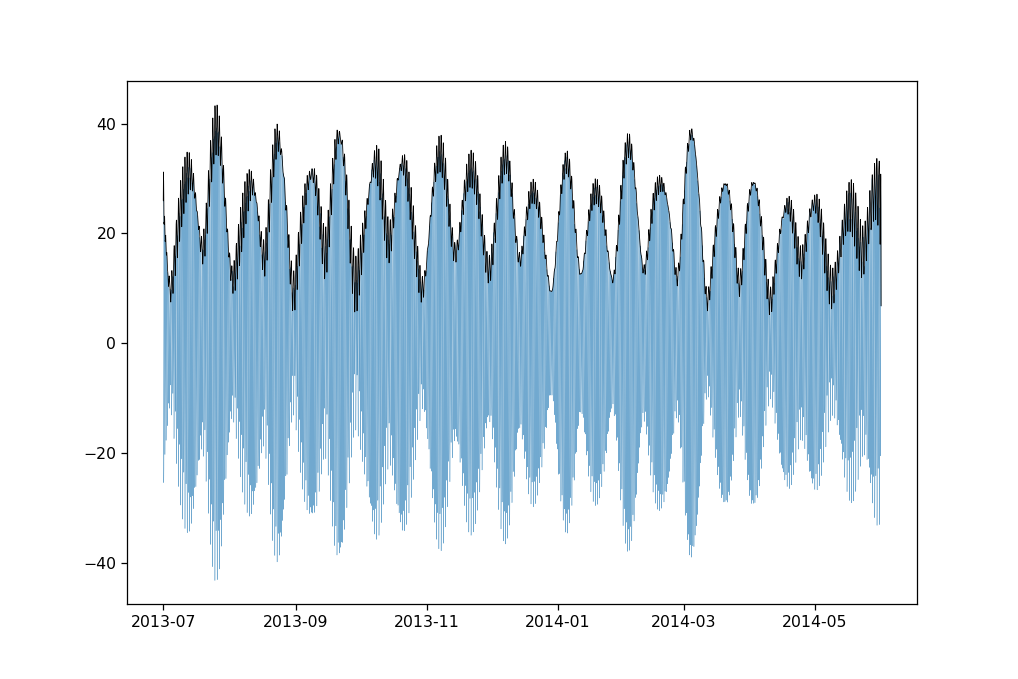

In [123]:
plt.figure(figsize=(9,6))
plt.plot(amp_new.time, amp_ts, lw=0.2)
plt.plot(amp_new.time, env, lw=0.5, c='k')

6.759774415077306e-05

In [48]:
t1990


array([7.414848e+08, 7.441632e+08, 7.468416e+08, 7.494336e+08,
       7.521120e+08, 7.547040e+08, 7.573824e+08, 7.600608e+08,
       7.624800e+08, 7.651584e+08, 7.677504e+08, 7.704288e+08])